# cats_vs_dogs

https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [1]:
#import paskages
import zipfile
import os
#from google.colab import files


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
%matplotlib inline


In [3]:
# Unzip the archive
local_zip = 'data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [4]:

base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'validation', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


ou can assign each of these directories to a variable so you can use it later.

In [5]:
train_dir = os.path.join(base_dir , 'train')
validation_dir = os.path.join(base_dir, 'validation')


In [6]:
# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

In [7]:
# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

In [8]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [9]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


For both cats and dogs, you have 1,000 training images and 500 validation images.

Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplotlib parameters:

In [10]:

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

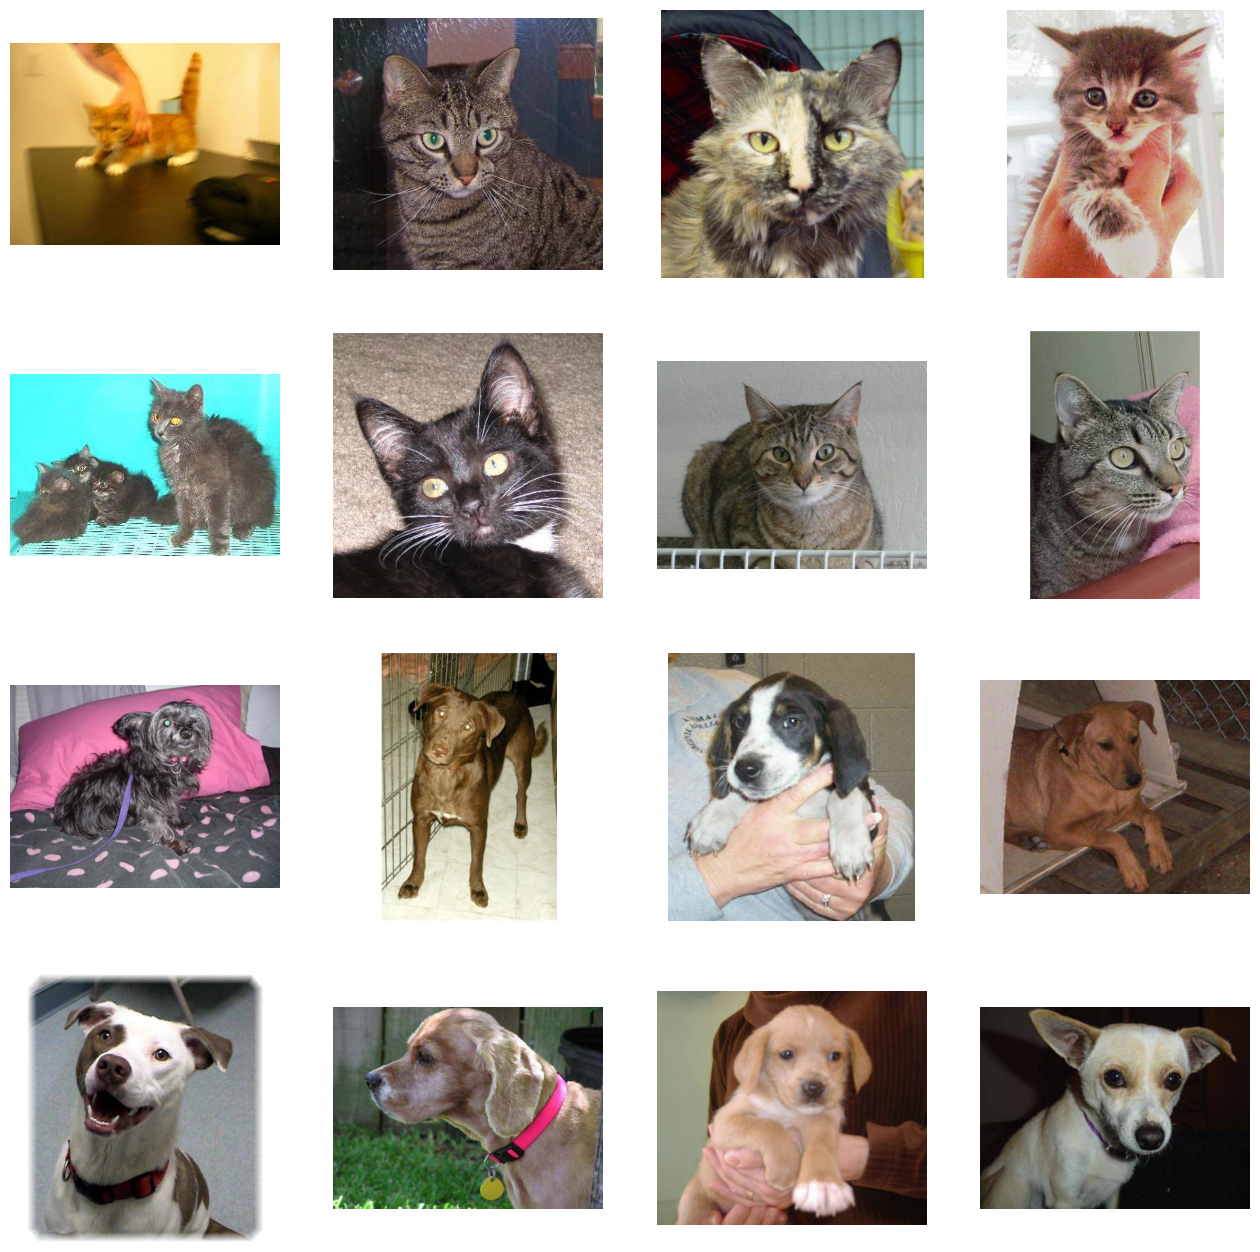

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### Building a Small Model from Scratch to get to ~72% Accuracy

In [15]:
model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16 ,(3,3)  ,activation="relu" , input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3) , activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64 , (3,3) , activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten data
    tf.keras.layers.Flatten(),
    
    #512 neuron hidden layer
    tf.keras.layers.Dense(512 , activation="relu"),
    
    #Only 1 output neuron
    #It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1 , activation="sigmoid")
])

Note that because you are facing a two-class classification problem, i.e. a binary classification problem, you will end the network with a sigmoid activation. The output of the network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [16]:
#You can review the architecture of the network with the model.summary() method:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 64)      

The output_shape column shows how the size of your feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.

Next, you'll configure the specifications for model training. You will train our model with the binary_crossentropy loss, because it's a binary classification problem and your final activation is a sigmoid. We will use the rmsprop optimizer with a learning rate of 0.001. During training, you will want to monitor classification accuracy.



NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)



In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
             loss="binary_crossentropy",
             metrics=['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [22]:
# All images will be rescaled by 1./255.
train_datagen=ImageDataGenerator(rescale= 1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator=train_datagen.flow_from_directory(
                                                    train_dir,
                                                    batch_size=20,
                                                    class_mode="binary",
                                                    target_size=(150, 150)                     
                                                            )

# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training

You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.



You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The loss and accuracy are great indicators of progress in training. loss measures the current model prediction against the known labels, calculating the result. accuracy, on the other hand, is the portion of correct guesses.

In [23]:
history=model.fit(train_generator , 
                 epochs=15,
                 validation_data=validation_generator)

Epoch 1/15
100/100 [==============================] - 49s 476ms/step - loss: 0.7502 - accuracy: 0.5750 - val_loss: 0.8830 - val_accuracy: 0.5030
Epoch 2/15
100/100 [==============================] - 32s 318ms/step - loss: 0.6451 - accuracy: 0.6735 - val_loss: 0.5966 - val_accuracy: 0.6690
Epoch 3/15
100/100 [==============================] - 32s 319ms/step - loss: 0.5410 - accuracy: 0.7340 - val_loss: 0.5746 - val_accuracy: 0.7110
Epoch 4/15
100/100 [==============================] - 34s 345ms/step - loss: 0.4449 - accuracy: 0.7980 - val_loss: 0.5644 - val_accuracy: 0.7230
Epoch 5/15
100/100 [==============================] - 37s 372ms/step - loss: 0.3590 - accuracy: 0.8375 - val_loss: 0.6338 - val_accuracy: 0.7040
Epoch 6/15
100/100 [==============================] - 32s 319ms/step - loss: 0.2508 - accuracy: 0.8935 - val_loss: 0.6939 - val_accuracy: 0.7310
Epoch 7/15
100/100 [==============================] - 32s 321ms/step - loss: 0.1765 - accuracy: 0.9310 - val_loss: 0.9136 - val_ac

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.



In [41]:
images = os.listdir("data//temp")

print(images)

['c1.jpeg', 'c2.jpeg', 'c3.jpg', 'c4.jpeg', 'c5.jpeg', 'c6.jpeg', 'c7.jpeg', 'c8.jpg', 'd1.jpeg', 'd2.jpeg', 'd3.jpeg', 'd4.jpeg', 'd5.jpeg', 'd6.jpeg', 'd7.jpeg']


In [42]:
for i in images:
    # predicting images
    path = 'data//temp//' + i
    print(path)

data//temp//c1.jpeg
data//temp//c2.jpeg
data//temp//c3.jpg
data//temp//c4.jpeg
data//temp//c5.jpeg
data//temp//c6.jpeg
data//temp//c7.jpeg
data//temp//c8.jpg
data//temp//d1.jpeg
data//temp//d2.jpeg
data//temp//d3.jpeg
data//temp//d4.jpeg
data//temp//d5.jpeg
data//temp//d6.jpeg
data//temp//d7.jpeg


In [43]:
for i in images:
    print()
    # predicting images
    path = 'data//temp//' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(i + " is a dog")
    else:
        print(i + " is a cat")


1/1 [==============================] - 0s 39ms/step
[0.9215782]
c1.jpeg is a dog

1/1 [==============================] - 0s 39ms/step
[8.0944716e-05]
c2.jpeg is a cat

1/1 [==============================] - 0s 39ms/step
[2.9142995e-05]
c3.jpg is a cat

1/1 [==============================] - 0s 38ms/step
[0.99960923]
c4.jpeg is a dog

1/1 [==============================] - 0s 37ms/step
[5.101864e-08]
c5.jpeg is a cat

1/1 [==============================] - 0s 39ms/step
[2.176362e-07]
c6.jpeg is a cat

1/1 [==============================] - 0s 41ms/step
[1.2502522e-06]
c7.jpeg is a cat

1/1 [==============================] - 0s 40ms/step
[0.00237871]
c8.jpg is a cat

1/1 [==============================] - 0s 42ms/step
[0.9958815]
d1.jpeg is a dog

1/1 [==============================] - 0s 39ms/step
[0.9999897]
d2.jpeg is a dog

1/1 [==============================] - 0s 38ms/step
[1.]
d3.jpeg is a dog

1/1 [==============================] - 0s 40ms/step
[1.]
d4.jpeg is a dog

1/1 [======

### Visualizing Intermediate Representations

o get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 [==============================] - 0s 95ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_19064\2491369796.py:44: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


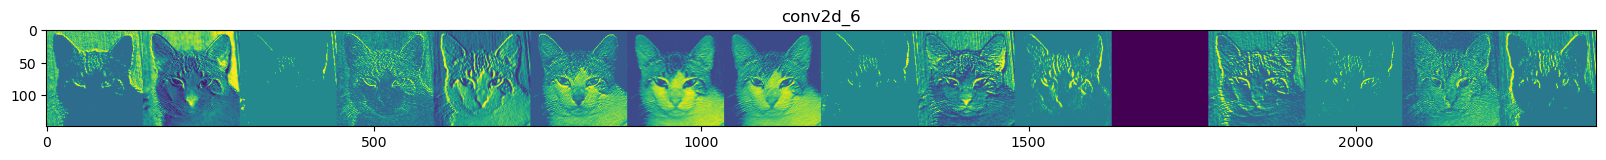

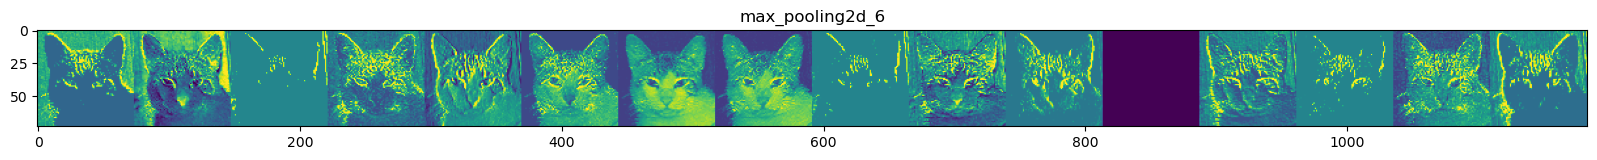

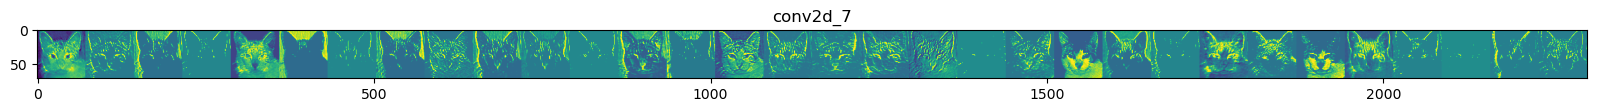

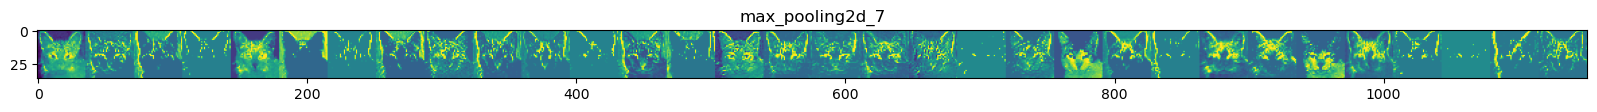

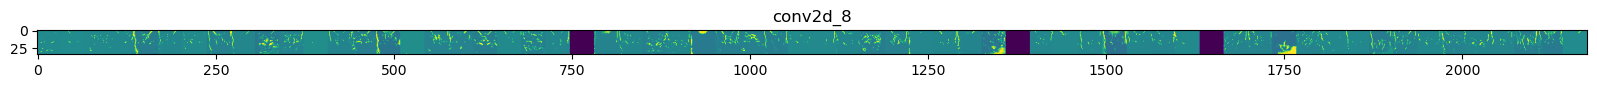

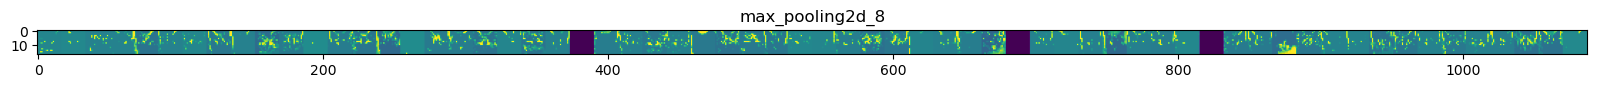

In [44]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called representation sparsity and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### Evaluating Accuracy and Loss for the Model

In [47]:
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

<Figure size 640x480 with 0 Axes>

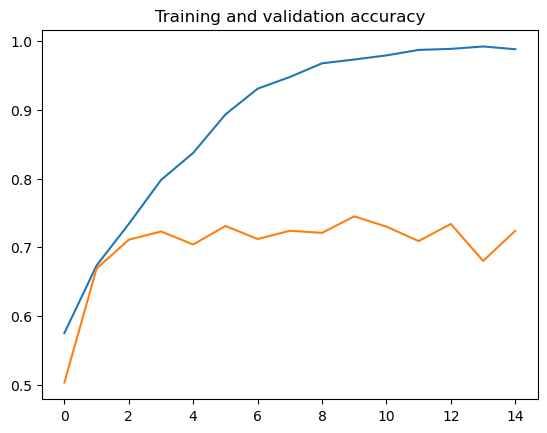

<Figure size 640x480 with 0 Axes>

In [50]:
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

Text(0.5, 1.0, 'Training and validation loss')

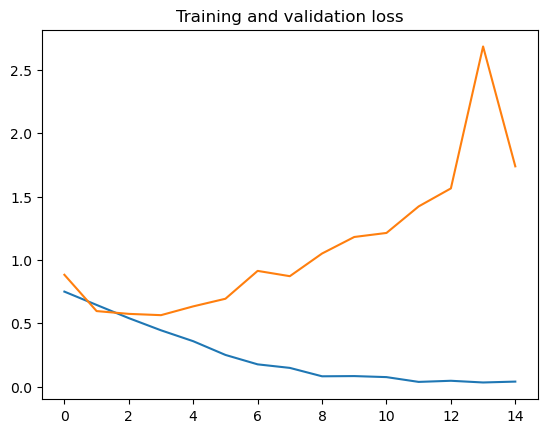

In [53]:
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

As you can see, the model is overfitting like it's getting out of fashion. The training accuracy (in blue) gets close to 100% while the validation accuracy (in orange) stalls as 70%. The validation loss reaches its minimum after only five epochs.

Since you have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that you are fitting the parameters of our model to a given dataset, how can you make sure that the representations learned by the model will be applicable to data it has never seen before? How do you avoid learning things that are specific to the training data?

In the next exercise, you'll look at ways to prevent overfitting in this classification model.